# Speed distributions $f(v)$ for each shard as well as our composite model


In [42]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
from PlotFuncs import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from scipy.stats import norm
import pandas

# Set plot rc params
plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

#######

# v range
n = 300
v = linspace(0.01,850.0,n)

# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
sig_beta = HaloModel.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)
day = 67.0 



# Load shards
df = pandas.read_csv('../data/FitShards.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun
weights = norm.pdf(Psun,loc=0.0,scale=1.0)/norm.pdf(0.0,loc=0.0,scale=1.0)
#weights = pops
weights /= sum(weights)


# Smooth cutoff or sharp cutoff?
SCO = True

# Smooth Speed distributions
fv_Iso_lab = SpeedDist_Triaxial(v,day,sig_iso) # Round halo
fv_Saus_lab = SpeedDist_Triaxial(v,day,sig_beta,SmoothCutoff=SCO) # Sausage
fv_Iso_gf = SpeedDist_Triaxial(v,day,sig_iso,GravFocus=True,SmoothCutoff=SCO) # Round halo
fv_Saus_gf = SpeedDist_Triaxial(v,day,sig_beta,GravFocus=True,SmoothCutoff=SCO) # Sausage
fv_Iso_gal = SpeedDist_Triaxial(v,day,sig_iso,GalFrame=True,SmoothCutoff=SCO) # Galactic frame Halo
fv_Saus_gal = SpeedDist_Triaxial(v,day,sig_beta,GalFrame=True,SmoothCutoff=SCO) # Galactic frame Sausage


v_s = velocities[0,:]
sig_s = dispersions[0,:]
fv_lab = weights[0]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s)
fv_gal = weights[0]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GalFrame=True)
fv_gf = weights[0]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GravFocus=True) # Focused
shard_label = ['S1']
shard_weights = weights[0]
for i in range(1,nshards):
    if names[i].endswith('a'):
        v_s = velocities[i,:]
        sig_s = dispersions[i,:]
        fv_lab1 = weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,SmoothCutoff=SCO)
        fv_gal1 = weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GalFrame=True,SmoothCutoff=SCO)
        fv_gf1 = weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GravFocus=True,SmoothCutoff=SCO) 
        
        v_s = velocities[i+1,:]
        sig_s = dispersions[i+1,:]
        fv_lab1 += weights[i+1]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,SmoothCutoff=SCO)
        fv_gal1 += weights[i+1]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GalFrame=True,SmoothCutoff=SCO)
        fv_gf1 += weights[i+1]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GravFocus=True,SmoothCutoff=SCO) 
        shard_label.append(names[i][:-1])
        shard_weights = append(shard_weights,weights[i]+weights[i+1])
        fv_lab = vstack((fv_lab,fv_lab1))
        fv_gal = vstack((fv_gal,fv_gal1))
        fv_gf = vstack((fv_gf,fv_gf1))
        
    elif not names[i].endswith('b'):
        v_s = velocities[i,:]
        sig_s = dispersions[i,:]
        fv_lab1 = weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,SmoothCutoff=SCO)
        fv_gal1 = weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GalFrame=True,SmoothCutoff=SCO)
        fv_gf1 = weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GravFocus=True,SmoothCutoff=SCO) 
        shard_label.append(names[i])
        shard_weights = append(shard_weights,weights[i])
        
        fv_lab = vstack((fv_lab,fv_lab1))
        fv_gal = vstack((fv_gal,fv_gal1))
        fv_gf = vstack((fv_gf,fv_gf1))

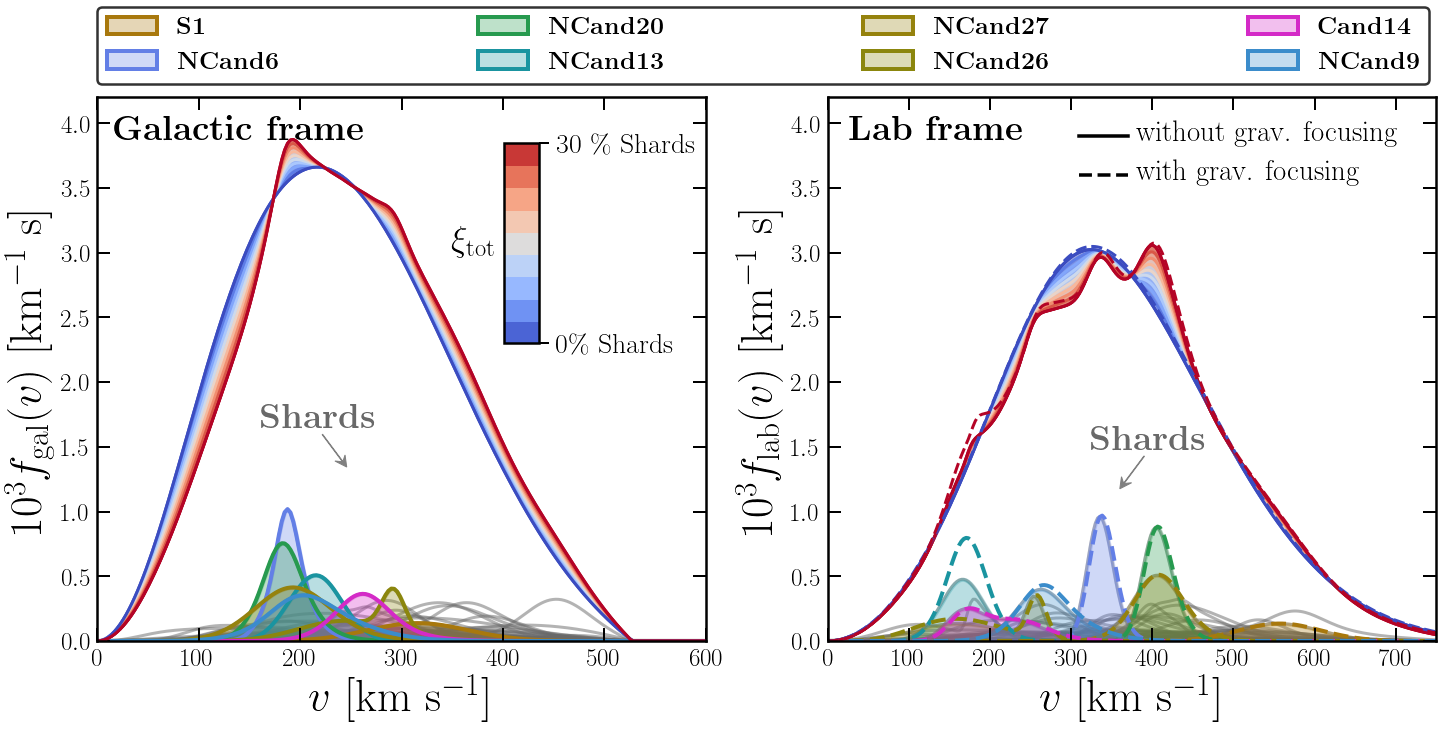

In [45]:
import matplotlib.cm as cm

# Figure setup
xlab = r"$v$ [km s$^{-1}$]"
ylab1 = r"$10^3 f_{\rm gal}(v)$ [km$^{-1}$ s]"
ylab2 = ylab1.replace('gal','lab')
fig,ax1,ax2 = MyDoublePlot(xlab,ylab1,xlab,ylab2,size_x=24,size_y=10,wspace=0.2)

# Smooth component
eta_saus = 0.2
fv0_gal = (1-eta_saus)*fv_Iso_gal + eta_saus*fv_Saus_gal
fv0_lab = (1-eta_saus)*fv_Iso_lab + eta_saus*fv_Saus_lab
fv0_gf = (1-eta_saus)*fv_Iso_gf + eta_saus*fv_Saus_gf


nshards = shape(shard_label)[0]


# Shards with varying xi
n_xi = 10
xi_max = 0.35
xi_vals = linspace(0.0,xi_max,n_xi)
col = (cm.coolwarm(linspace(0,1,n_xi)))
cmap = cm.coolwarm
y2_lab = 1e3*(xi_vals[-1]*sum(fv_lab,0)+(1.0-xi_vals[-1])*fv0_lab)
y2_gal = 1e3*(xi_vals[-1]*sum(fv_gal,0)+(1.0-xi_vals[-1])*fv0_gal)
y2_gf = 1e3*(xi_vals[-1]*sum(fv_gf,0)+(1.0-xi_vals[-1])*fv0_gf)
fvs_lab = sum(fv_lab,0)
fvs_gf = sum(fv_gf,0)
fvs_gal = sum(fv_gal,0)
for i in range(0,n_xi):
    xi = xi_vals[i]
    ax1.fill_between(v,1e3*(xi*fvs_gal+(1-xi)*fv0_gal),y2=y2_gal,color=col[i,:],alpha=0.5)
    ax1.plot(v,1e3*(xi*fvs_gal+(1-xi)*fv0_gal),'-',color=col[i,:],linewidth=3)
    
    ax2.fill_between(v,1e3*(xi*fvs_lab+(1-xi)*fv0_lab),y2=y2_lab,color=col[i,:],alpha=0.5)
    ax2.plot(v,1e3*(xi*fvs_lab+(1-xi)*fv0_lab),'-',color=col[i,:],linewidth=3)
    
    
# Range
ax1.plot(v,1e3*fv0_gal,'-',color=col[0,:],linewidth=3)
ax1.plot(v,y2_gal,'-',color=col[-1,:],linewidth=3)
ax2.plot(v,1e3*fv0_lab,'-',color=col[0,:],linewidth=3)
ax2.plot(v,y2_lab,'-',color=col[-1,:],linewidth=3)
ax2.plot(v,1e3*fv0_gf,'--',color=col[0,:],linewidth=3)
ax2.plot(v,y2_gf,'--',color=col[-1,:],linewidth=3)



# second "legend" for with/without GF
ax2.plot([310,370],[3.9,3.9], 'k-',linewidth=3.5)
ax2.plot([310,370],[3.6,3.6], 'k--',linewidth=3.5)
ax2.text(380,3.9-0.038,'without grav. focusing',fontsize=29)
ax2.text(380,3.6-0.038,'with grav. focusing',fontsize=29)

# Plot individual streams
#ax1.plot(v,1e3*fvs_gal/2,'g-',lw=3)
#ax2.plot(v,1e3*fvs_lab/2,'g-',lw=3)
for i in range(0,nshards):
    ax1.plot(v,1e3*fv_gal[i,:],color='dimgray',alpha=0.5,linewidth=3,zorder=0) 
    ax2.plot(v,1e3*fv_lab[i,:],color='dimgray',alpha=0.5,linewidth=3,zorder=0)



nex = 8
#sortw = argsort(shard_weights)
sortw = argsort(amax(fv_gal,axis=1))
Examples = [shard_label[i] for i in flipud(sortw[-(nex):])]
if 'S1' in Examples:
    Examples.remove('S1')
    Examples = append('S1',Examples)
else:
    Examples = append('S1',Examples)
    Examples = Examples[0:-1]

import cmocean
col_ex = (cmocean.cm.phase(linspace(0,1,nshards)))
alph= 0.3
for i in range(0,size(Examples)):
    j = shard_label.index(Examples[i])
    ax1.fill_between(v,1e3*fv_gal[j,:],color=col_ex[j,:],lw=4,alpha=alph,zorder=1) 
    ax1.plot(v,1e3*fv_gal[j,:],color=col_ex[j,:],lw=4,zorder=1) 
    ax1.fill_between([-1,-1],[-1,-3],facecolor=col_alpha(col_ex[j,:],alpha=alph),edgecolor=col_ex[j,:],lw=4,label=r'{\bf '+Examples[i]+r'}',zorder=1)
    
    ax2.fill_between(v,1e3*fv_lab[j,:],color=col_ex[j,:],lw=4,alpha=alph,zorder=1) 
    ax2.plot(v,1e3*fv_gf[j,:],'--',color=col_ex[j,:],lw=4,zorder=1)

# Legend lines
leg = ax1.legend(loc='upper left',fontsize=25,edgecolor='k',ncol=4,bbox_to_anchor=(-0.02, 1.19), columnspacing=8)
leg.get_frame().set_linewidth(2.5)
 
    
# Plot fiddling
ax1.set_xlim(left=0,right=600.0)
ax1.set_ylim(bottom=0,top=4.2)
ax2.set_xlim(left=0,right=750.0)
ax2.set_ylim(bottom=0,top=4.2)
plt.gcf().text(0.70,0.39,r'{\bf Shards}',fontsize=35,color='dimgray')
plt.gcf().text(0.22,0.42,r'{\bf Shards}',fontsize=35,color='dimgray')
plt.gcf().text(0.135,0.82,r'{\bf Galactic frame}',fontsize=35,color='k')
plt.gcf().text(0.56,0.82,r'{\bf Lab frame}',fontsize=35,color='k')

ax1.arrow(0.37, 0.38, 0.04, -0.06, transform=ax1.transAxes,length_includes_head=True,head_width=0.02, head_length=0.02, overhang=0.4,edgecolor='gray',facecolor='gray')
ax2.arrow(0.52, 0.34, -0.04, -0.06, transform=ax2.transAxes,length_includes_head=True,head_width=0.02, head_length=0.02, overhang=0.4,edgecolor='gray',facecolor='gray')



# # Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbar_max = r'30 \% Shards'
cbar_min = r'0\% Shards'
cbaxes = inset_axes(ax1, width="5%", height="50%", bbox_to_anchor=[-30, 200, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi))
f = plt.gcf().get_children()
cbar = f[3]
cbar.set_yticklabels([cbar_min, cbar_max])  # vertically oriented colorbar
cbar.tick_params(labelsize=28) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)
plt.gcf().text(0.33,0.66,r'$\xi_{\rm tot}$',fontsize=35,color='k')


# Save figure
plt.show()
pltname = 'Shards_fv'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

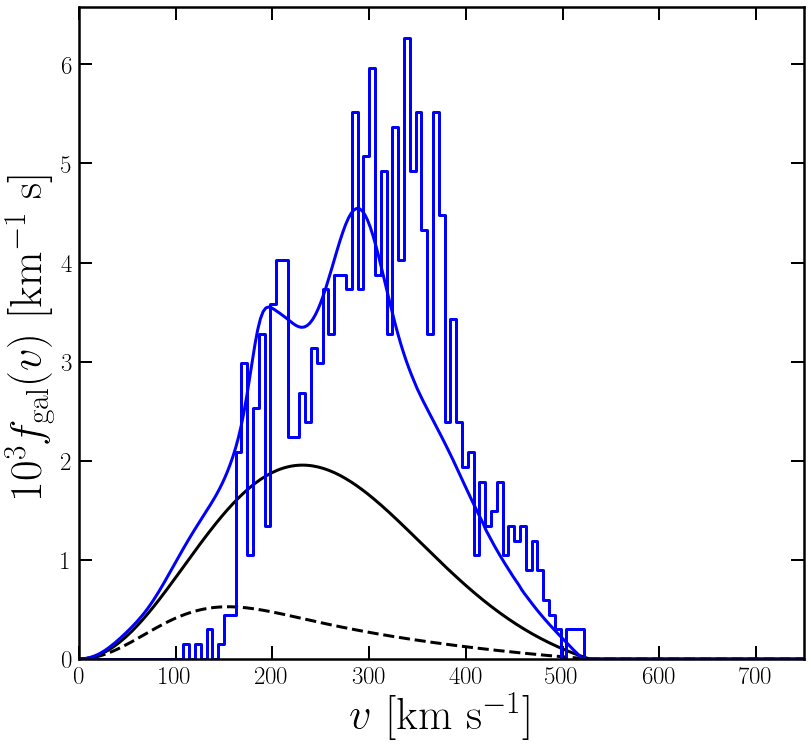

In [16]:
fig,ax = MySquarePlot(xlab,ylab1)
eta = 0.2

plt.plot(v,1e3*(1-xi_max)*(1-eta)*fv_Iso_gal,'k-',lw=3)
plt.plot(v,1e3*(1-xi_max)*eta*fv_Saus_gal,'k--',lw=3)


df_S = pandas.read_csv('../data/GAIA_SDSS_Shards.csv')
all_names = names = df_S.group_id.unique()
df_sel = df_S
vv = sqrt((df_sel.GalRVel)**2.0+(df_sel.GalTVel)**2.0+(df_sel.GalzVel)**2.0)
fv,vbins = histogram(vv,bins=100,normed=True,range=(0,600))
plt.step(vbins[1:],1e3*fv,'-',color='b',lw=3)

fv_gal1 = zeros(shape=n)
for i in range(0,nshards):
    v_s = velocities[i,:]
    sig_s = dispersions[i,:]
    fv_gal1 += weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GalFrame=True,SmoothCutoff=SCO)

plt.plot(v,1e3*fv_gal1/trapz(fv_gal1,v),'b-',lw=3)

        



# df_highE = pandas.read_csv('../data/Gaia-SDSS_highE.csv')
# dfc = df_highE.loc[df_highE['feh'] < -1.4]
# vv = sqrt((dfc.GalRVel)**2.0+(dfc.GalphiVel)**2.0+(dfc.GalzVel)**2.0)
# fv,vbins = histogram(vv,bins=50,normed=True,range=(0,600))
# plt.plot(vbins[1:],1e3*fv*xi_max,'--',color='Crimson',lw=3)

# dfc = df_highE.loc[df_highE['feh'] < -2.0]
# vv = sqrt((dfc.GalRVel)**2.0+(dfc.GalphiVel)**2.0+(dfc.GalzVel)**2.0)
# fv,vbins = histogram(vv,bins=50,normed=True,range=(0,600))
# plt.plot(vbins[1:],1e3*fv*xi_max,'-',color='Crimson',lw=3)

plt.xlim([0,750])
ax.set_ylim(bottom=0.0)
plt.show()

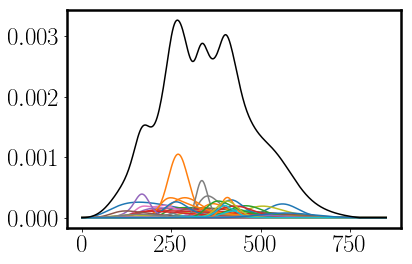

In [25]:
for i in range(0,nshards):
    plt.plot(v,fv_lab[i,:])
plt.plot(v,sum(fv_lab,0),'k-')
plt.show()

In [26]:
trapz(fvs_lab,v)

0.99999999999999989

In [33]:
x_meens,x_covs,v_meens,v_covs,fehs,pops,Psun = FitStars(df_sel)
print v_meens
print sqrt(sum(v_meens[0,:]**2.0))

[[  27.98272107 -275.08345117   17.98607471]]
277.087417021


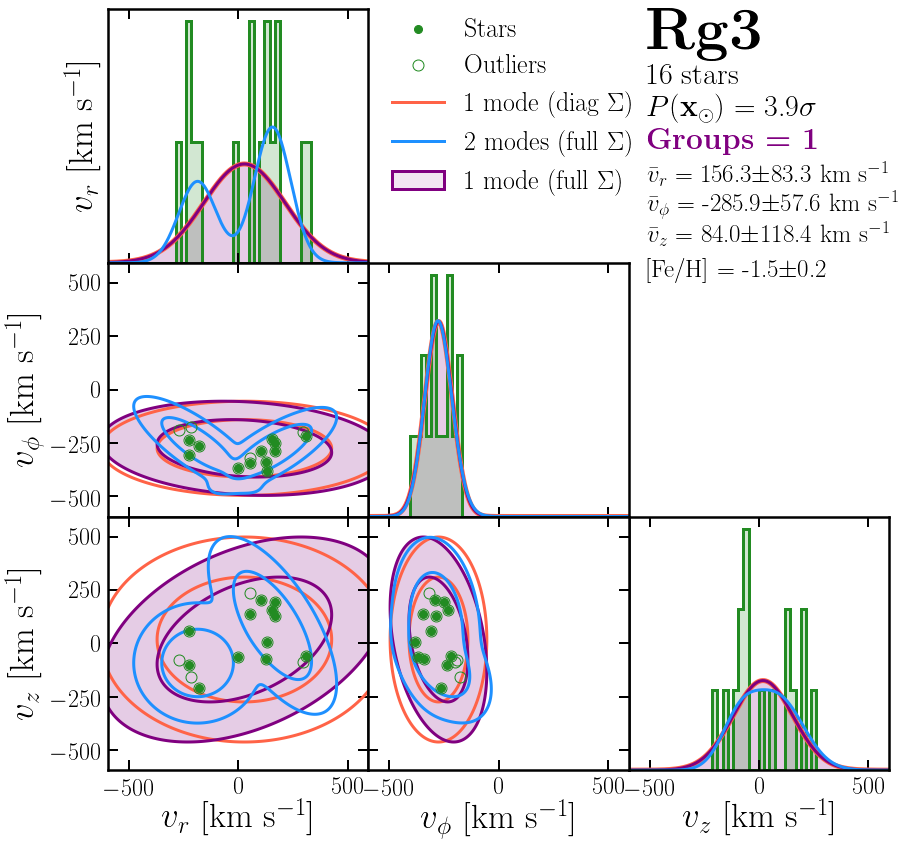

In [24]:
fig = VelocityTriangle(df_sel)
plt.show()